# Look at Line2line channel gradients down centre of channel 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
# points_x_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_x.npy')
# points_y_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_y.npy')
# ice_thickn_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_ice_thickn.npy')

In [3]:
points_x_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
points_y_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
ice_thickn_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')

In [4]:
it = ice_thickn_chan[10,:]
x = points_x_chan[10,:]
y = points_y_chan[10,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it})

points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")

In [5]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()

In [6]:
add_distance_to_gdf(gdf)

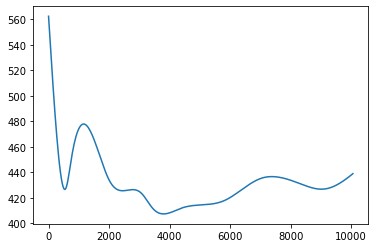

In [7]:
plt.plot(gdf.distan_cum,gdf.ice_thickn)

In [8]:
mins = gdf[np.abs(gdf.ice_thickn.diff()) < 0.02].copy()
mins

,x,y,ice_thickn,geometry,dx,distan_cum
39,-380566.554561,-725505.110665,477.942561,POINT (-380566.555 -725505.111),30.108031,1175.974719
82,-379417.558523,-726115.959896,425.628871,POINT (-379417.559 -726115.960),30.184097,2477.619793
93,-379137.578584,-726293.505595,426.462508,POINT (-379137.579 -726293.506),30.156004,2809.261845
126,-378534.257876,-727055.863929,407.431964,POINT (-378534.258 -727055.864),30.271119,3803.204671
243,-377159.256560,-730272.327497,436.707408,POINT (-377159.257 -730272.327),31.618730,7364.433349
244,-377158.157654,-730303.945635,436.704795,POINT (-377158.158 -730303.946),31.637229,7396.070578
299,-376890.098016,-731865.049504,426.840682,POINT (-376890.098 -731865.050),26.944355,9007.186819
300,-376873.320597,-731886.283927,426.844722,POINT (-376873.321 -731886.284),27.062566,9034.249385


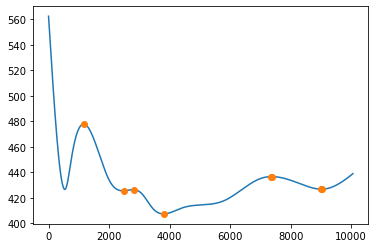

In [9]:
plt.plot(gdf.distan_cum,gdf.ice_thickn)
plt.plot(mins.distan_cum,mins.ice_thickn,'o')

In [10]:
gdf['ditdx'] = gdf.ice_thickn.diff()/gdf.dx

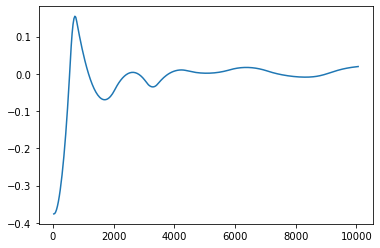

In [11]:
plt.plot(gdf.distan_cum,gdf.ditdx)

### Plot this against the REMA melt zone

In [12]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100

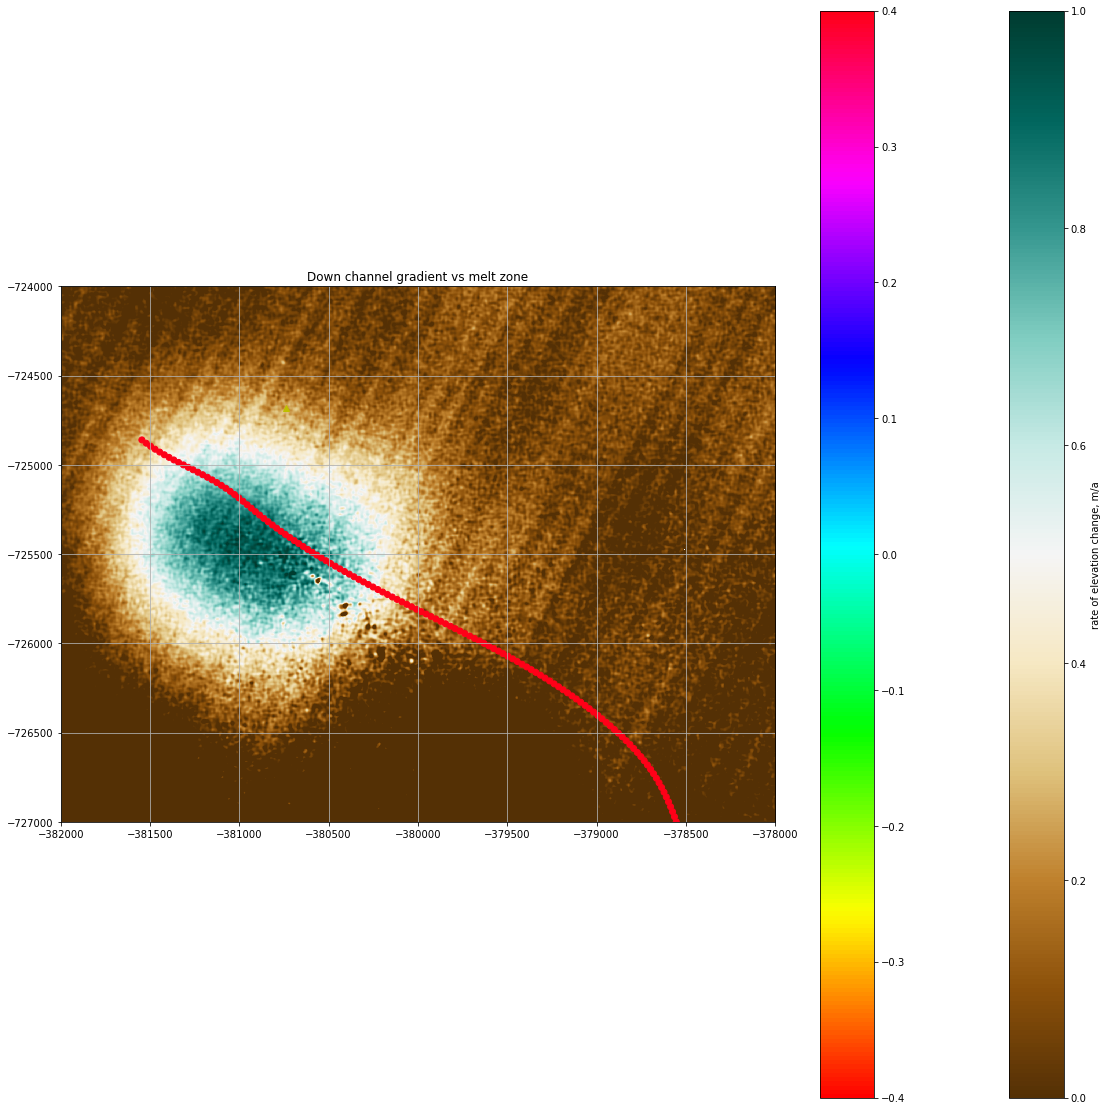

In [13]:
#rema
v=[0,1]    

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent, vmin=v[0],vmax=v[1],cmap='BrBG')
cb = plt.colorbar()
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,vmin=-0.4, vmax=0.4,cmap='hsv')

plt.colorbar()
plt.title('Down channel gradient vs melt zone')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


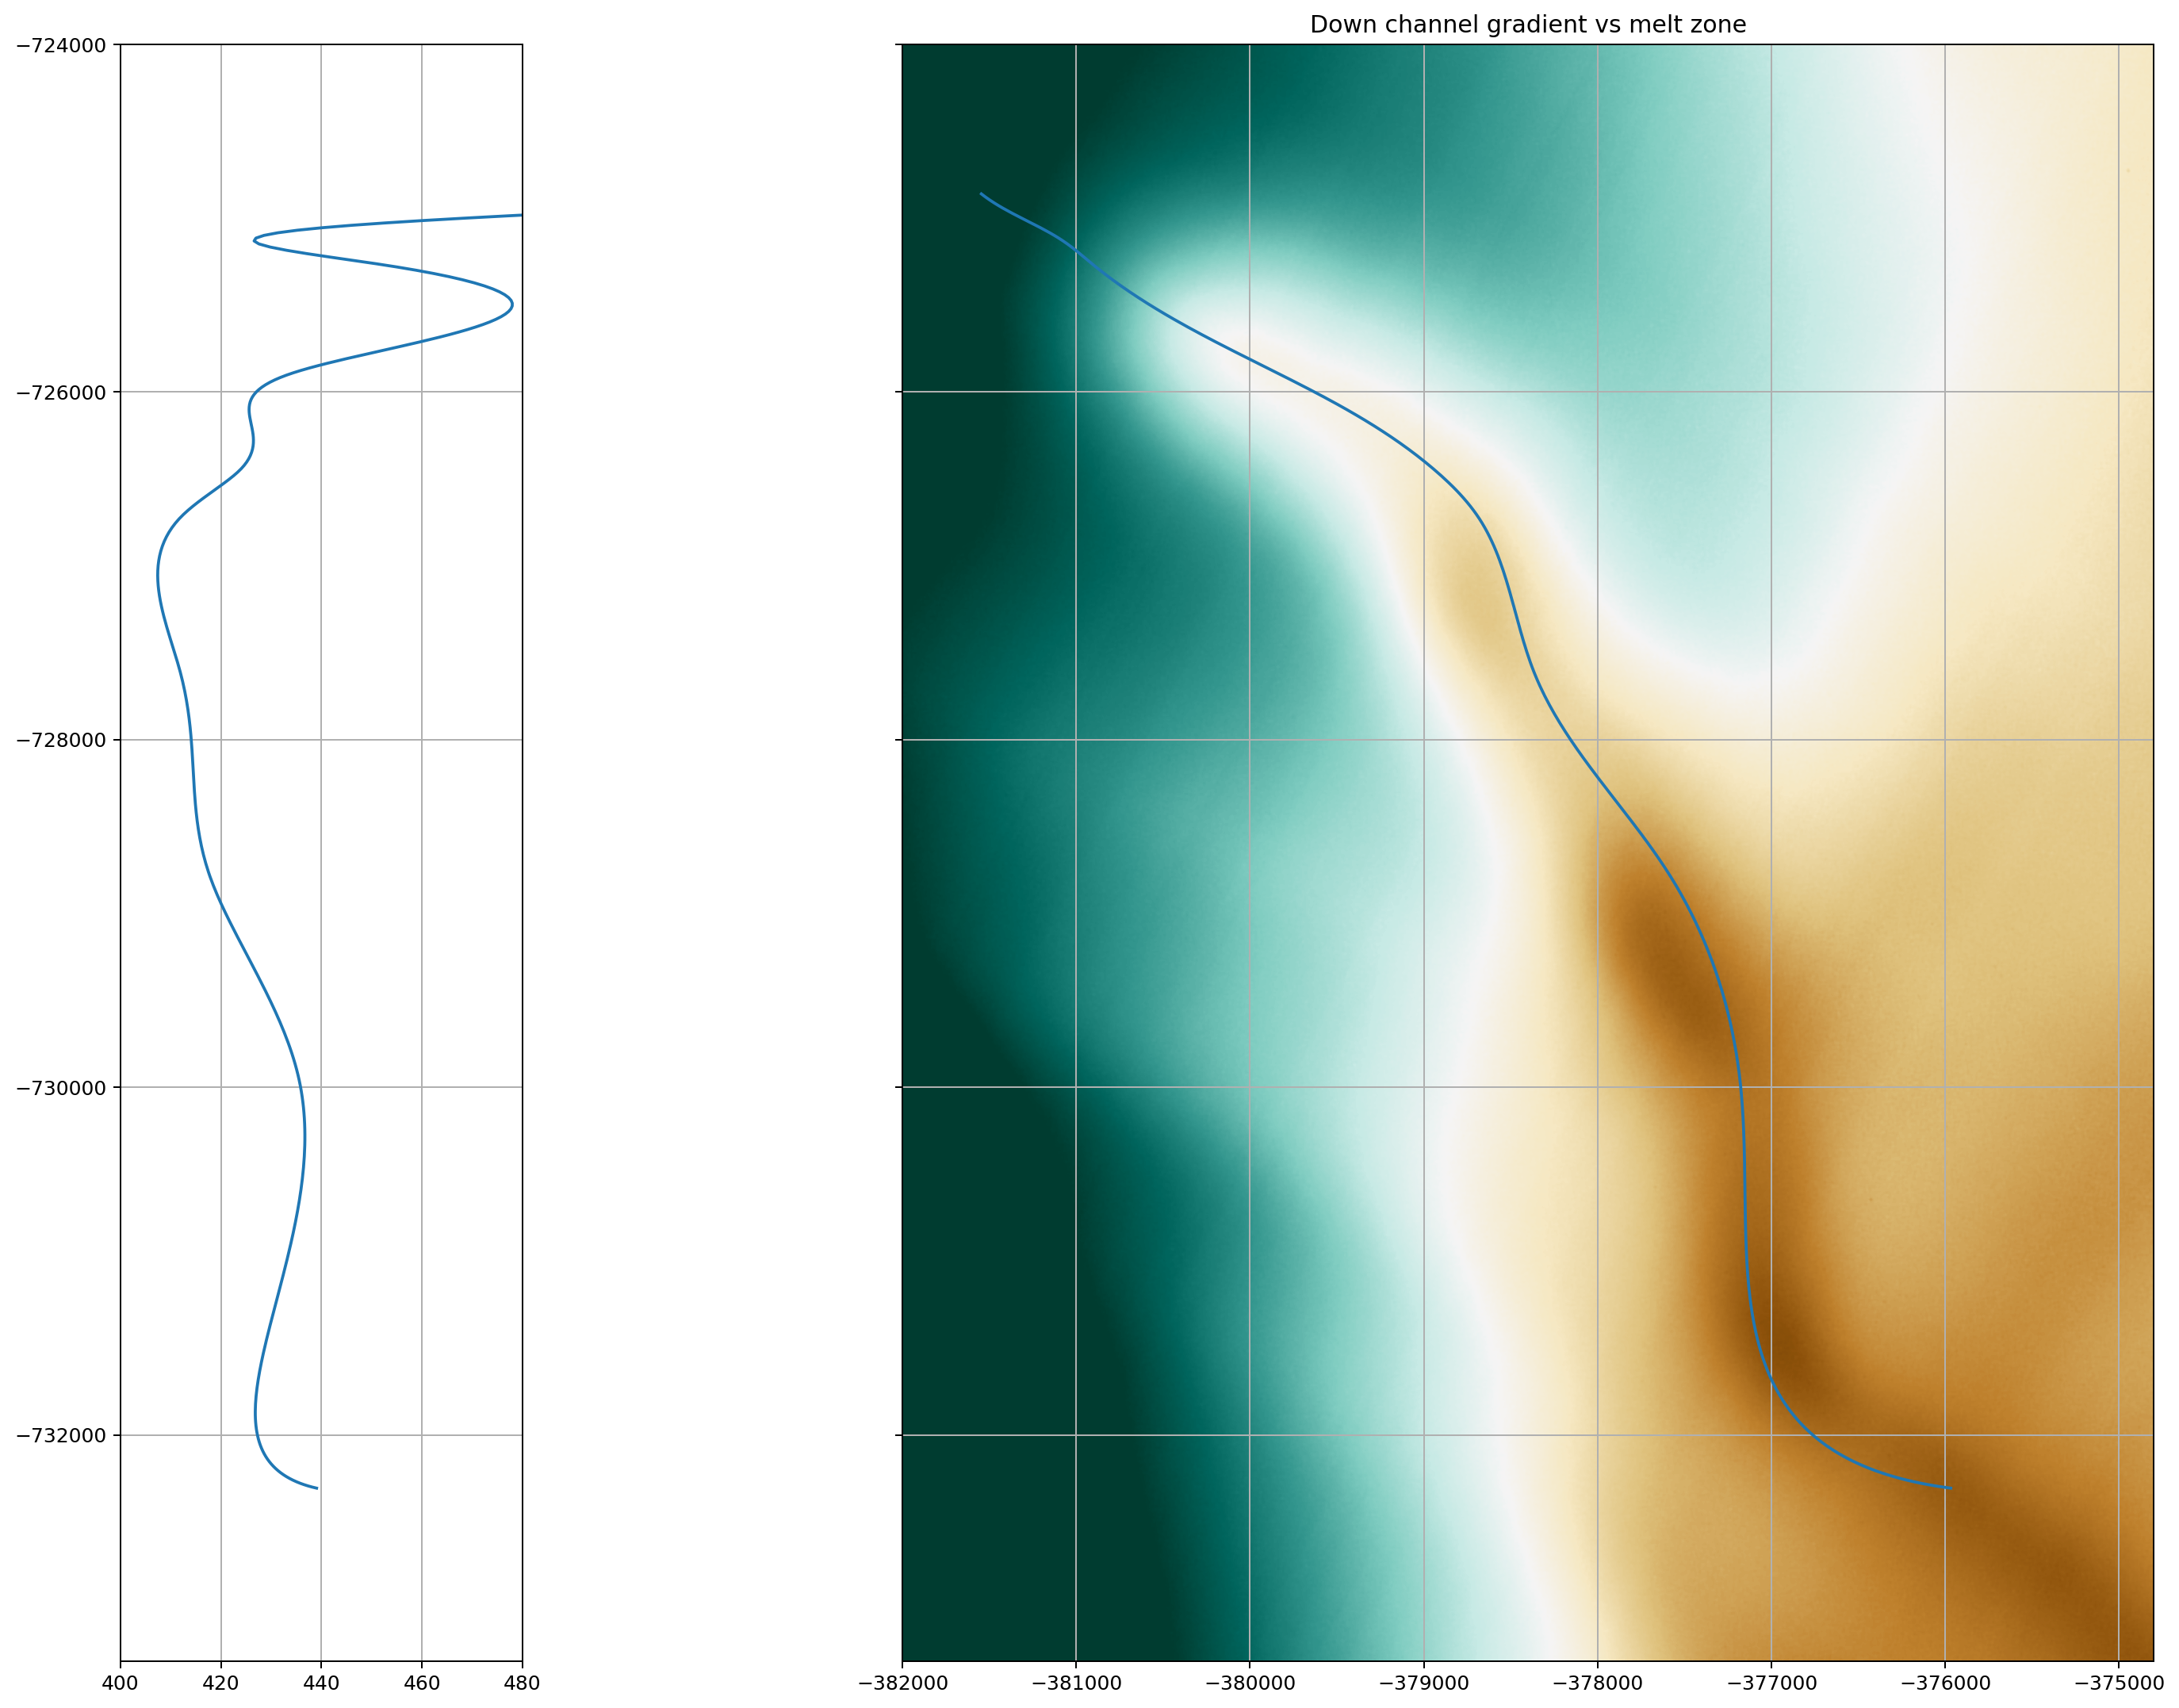

In [14]:

#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[1, 4],'height_ratios':[1]},
                               figsize=(20,15),dpi=180)#rema ,constrained_layout=True
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]

ax2.imshow(im_REMA,extent=extent_REMA,vmin=0.2,vmax=0.7, cmap='BrBG')
# cb = plt.colorbar()
# cb.set_label('surface elevation (?)')
# cb.set_label('rate of elevation change, m/a')
ax2.plot( gdf.x,gdf.y)
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.grid()

ax1.plot(gdf.ice_thickn,gdf.y)
ax1.set_xlim([400, 480])
ax1.set_ylim([-733300,-724000])

ax2.set_title('Down channel gradient vs melt zone')

ax1.grid()
fig.show()

In [25]:
%matplotlib qt


#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax2, ax1) = plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[4, 1],'height_ratios':[1]},
                               figsize=(6.5,15),dpi=180)#rema ,constrained_layout=True
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]

ax2.imshow(im_REMA,extent=extent_REMA,vmin=0.2,vmax=0.7, cmap='BrBG')
# cb = plt.colorbar()
# cb.set_label('surface elevation (?)')
# cb.set_label('rate of elevation change, m/a')
ax2.plot( gdf.x,gdf.y)
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.set_xlabel('UTM x, m')
ax2.set_ylabel('UTM y, m')
ax2.grid()

ax1.plot(gdf.ice_thickn,gdf.y)
# ax1.set_xlim([400, 480])
ax1.set_ylim([-733300,-724000])
ax1.set_xlabel('ice thickness, m')
# ax1.set_ylabel('UTM y, m')

# ax2.set_title('Down channel gradient vs melt zone')

ax1.grid()
fig.show()